In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 16,
    })


from fiesta.train.Benchmarker import Benchmarker
from fiesta.inference.lightcurve_model import AfterglowFlux, BullaLightcurveModel

In [2]:
def high_error_fraction(test, pred, filt):
    err = np.max(np.abs(test[filt]-pred[filt]), axis=1)

    err = err[(~np.isnan(err)) & (~np.isinf(err))]

    return np.sum(err >1) / len(err)
    

## Afterglowpy tophat

In [3]:
import h5py

with h5py.File("/home/aya/work/hkoehn/fiesta/fiesta/surrogates/GRB/training_data/pyblastafterglow_tophat_raw_data.h5") as f:
    print(f["test"]["X"].shape)

(7680, 8)


In [4]:
FILTERS = ["radio-6GHz", "bessellv", "X-ray-5keV"]


model1 = AfterglowFlux("afgpy_tophat_MLP",
                        filters = FILTERS)

model2 = AfterglowFlux("afgpy_tophat",
                        filters = FILTERS)


benchmarker1 = Benchmarker(
                    model = model1,
                    data_file = "/home/aya/work/hkoehn/fiesta/fiesta/surrogates/GRB/training_data/afterglowpy_tophat_raw_data.h5",
                    metric_name = "L2"
                    )

benchmarker2 = Benchmarker(
                    model = model2,
                    data_file = "/home/aya/work/hkoehn/fiesta/fiesta/surrogates/GRB/training_data/afterglowpy_tophat_raw_data.h5",
                    metric_name = "L2"
                    )

10:43 fiesta INFO    : Loading surrogate afgpy_tophat_MLP. This surrogate should only be used in the following parameter ranges:
10:43 fiesta INFO    : 	 inclination_EM: (0, 1.5707963267948966)
10:43 fiesta INFO    : 	 log10_E0: (47, 57)
10:43 fiesta INFO    : 	 thetaCore: (0.01, 0.6283185307179586)
10:43 fiesta INFO    : 	 log10_n0: (-6, 2)
10:43 fiesta INFO    : 	 p: (2.01, 3)
10:43 fiesta INFO    : 	 log10_epsilon_e: (-4, 0)
10:43 fiesta INFO    : 	 log10_epsilon_B: (-8, 0)
10:43 fiesta INFO    : Surrogate afgpy_tophat_MLP is loading with the following filters: ['radio-6GHz', 'bessellv', 'X-ray-5keV'].
10:43 fiesta INFO    : Loaded for surrogate afgpy_tophat_MLP from /nfs/aya/work/hkoehn/fiesta/fiesta/surrogates/GRB/afgpy_tophat_MLP/model.
10:43 fiesta INFO    : Loading surrogate afgpy_tophat. This surrogate should only be used in the following parameter ranges:
10:43 fiesta INFO    : 	 inclination_EM: (0, 1.5707963267948966)
10:43 fiesta INFO    : 	 log10_E0: (47, 57)
10:43 fiesta 

Loaded filters are: ['radio-6GHz', 'bessellv', 'X-ray-5keV'].
Loaded filters are: ['radio-6GHz', 'bessellv', 'X-ray-5keV'].


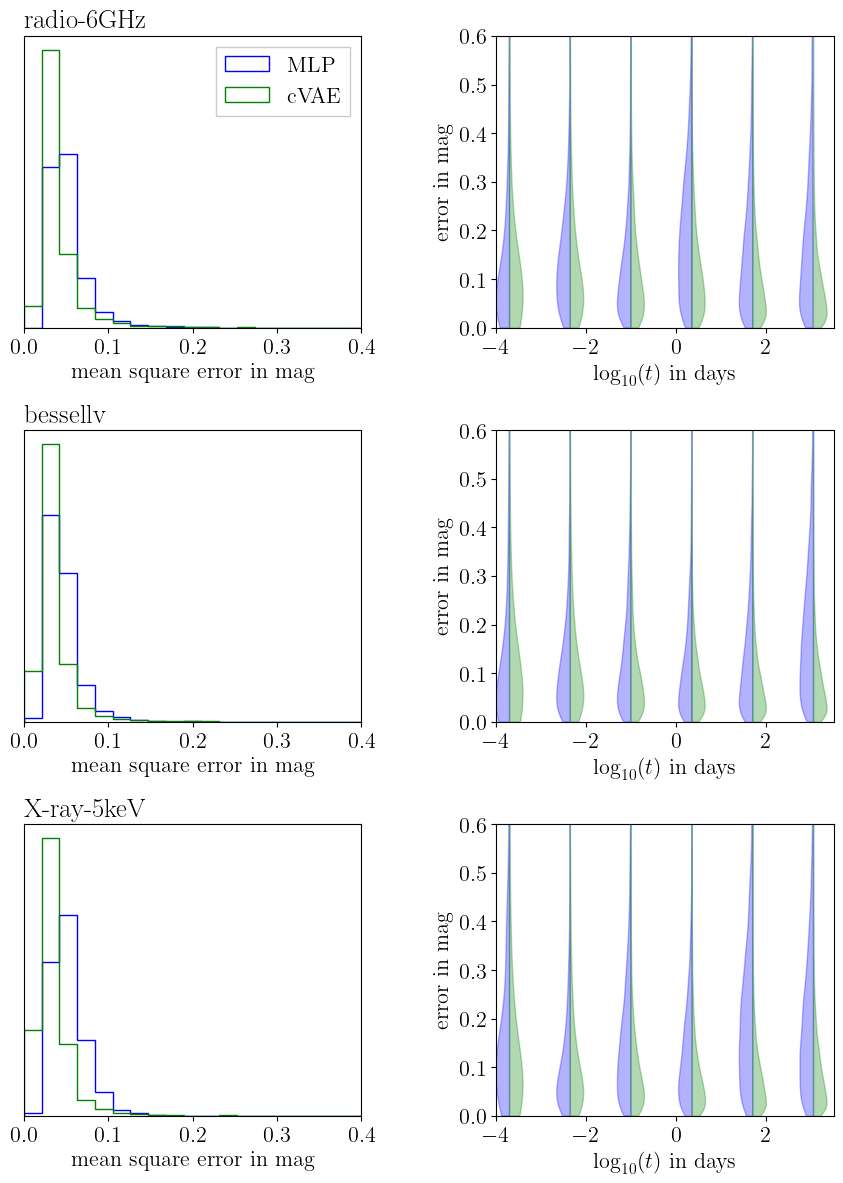

In [5]:
fig, ax = plt.subplots(3, 2, figsize = (9, 12))
fig.subplots_adjust(wspace = 0.4, hspace =0.35, bottom = 0.05, top = 0.95, left = 0.05, right = 0.95)

for filter, cax in zip(FILTERS, ax[:,0]):

    cax.hist(benchmarker1.error[filter], color = "blue", histtype = "step", bins = np.linspace(0, 0.4, 20), density = True, label = "MLP")
    cax.hist(benchmarker2.error[filter], color = "green", histtype = "step", bins = np.linspace(0, 0.4, 20), density = True, label = "cVAE")
    cax.set_yticks([])
    cax.set_xlabel("mean square error in mag")
    cax.set_xlim((0,0.4))
    cax.set_title(filter, loc = "left")

for filter, cax in zip(FILTERS, ax[:,1]):
    error = np.abs(benchmarker1.pred_mag[filter] - benchmarker1.test_mag[filter])
    error[np.isinf(error) | np.isnan(error)] = 0.
    indices = np.linspace(10, len(model1.times)-10, 6).astype(int)
    parts1 = cax.violinplot(error[:, indices], positions=np.log10(model1.times[indices]), widths=0.6, side="low", showextrema=False, points=500)
    for pc in parts1["bodies"]:
        pc.set_facecolor("blue")
        pc.set_edgecolor("blue")

    error = np.abs(benchmarker2.pred_mag[filter] - benchmarker2.test_mag[filter])
    error[np.isinf(error) | np.isnan(error)] = 0.
    indices = np.linspace(10, len(model2.times)-10, 6).astype(int)
    parts2 = cax.violinplot(error[:, indices], positions=np.log10(model2.times[indices]), widths=0.6, side="high", showextrema=False, points=500)
    for pc in parts2["bodies"]:
        pc.set_facecolor("green")
        pc.set_edgecolor("green")

    cax.set(xlabel = "$\\log_{10}(t)$ in days", ylabel = "error in mag", xscale = "linear", xlim = (-4., 3.5), ylim = (0,0.6))

ax[0,0].legend(fancybox=False, framealpha=1, fontsize = 16)
fig.savefig("./benchmark_afgpy_tophat.pdf", dpi =300)

In [7]:
high_error_fraction(benchmarker2.test_mag, benchmarker2.pred_mag, "bessellv")

0.0538971807628524

In [21]:
error1 = np.abs(benchmarker1.test_mag["bessellv"] - benchmarker1.pred_mag["bessellv"])

error2 = np.abs(benchmarker2.test_mag["bessellv"] - benchmarker2.pred_mag["bessellv"])

In [40]:
np.argsort(error1[:,200] - error2[:,200])[-100:]

array([4782, 5362, 4474,  495, 2388,  806, 5209, 2432, 1408,  665, 2357,
       5651,  819, 2820, 3613, 3970,  278, 6133, 1040, 4395, 5999, 2096,
       5797, 5754, 3632, 5591, 4244,  954, 2174,  591,   45,  262, 4371,
       7163, 7463, 1860, 2821,  133, 5965, 1188, 2600, 4774, 2709, 1146,
       1459,  469, 6822, 4362,  496, 5281,  126, 5165,  503, 4839, 5566,
       2077, 2960, 6314, 1671, 6481, 5440, 5047, 2615,  662,  357, 1406,
       3106, 6177, 5356,  464, 7414, 3299, 4913, 2996, 1011, 6551, 5911,
       5483, 5640, 3430, 4356, 7459, 6638, 7196, 6306, 6146,  437, 3893,
        237,  185,  647, 5796, 6272, 1401, 7352, 6688, 5236, 1758,  170,
       5211])

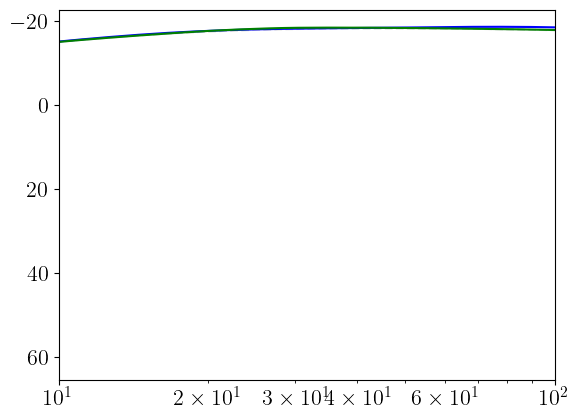

In [45]:
plt.xlim(10, 100)

plt.plot(benchmarker1.times, benchmarker1.test_mag["bessellv"][45], linestyle="dashed", color="lightgrey")
plt.plot(benchmarker1.times, benchmarker1.pred_mag["bessellv"][45], color="blue")
plt.plot(benchmarker2.times, benchmarker2.pred_mag["bessellv"][45], color="green")

plt.xscale("log")
plt.gca().invert_yaxis()

## Afterglowpy gaussian

In [31]:
FILTERS = ["radio-6GHz", "bessellv", "X-ray-5keV"]


model1 = AfterglowFlux("afgpy_gaussian_MLP",
                        filters = FILTERS)

model2 = AfterglowFlux("afgpy_gaussian",
                        filters = FILTERS)


benchmarker1 = Benchmarker(
                    model = model1,
                    data_file = "/home/aya/work/hkoehn/fiesta/fiesta/surrogates/GRB/training_data/afterglowpy_gaussian_raw_data.h5",
                    metric_name = "L2"
                    )

benchmarker2 = Benchmarker(
                    model = model2,
                    data_file = "/home/aya/work/hkoehn/fiesta/fiesta/surrogates/GRB/training_data/afterglowpy_gaussian_raw_data.h5",
                    metric_name = "L2"
                    )

17:47 fiesta INFO    : Loading surrogate afgpy_gaussian_MLP. This surrogate should only be used in the following parameter ranges:
17:47 fiesta INFO    : 	 inclination_EM: (0, 1.5707963267948966)
17:47 fiesta INFO    : 	 log10_E0: (47, 57)
17:47 fiesta INFO    : 	 thetaCore: (0.01, 0.6283185307179586)
17:47 fiesta INFO    : 	 alphaWing: (0.2, 3.5)
17:47 fiesta INFO    : 	 log10_n0: (-6, 2)
17:47 fiesta INFO    : 	 p: (2.01, 3)
17:47 fiesta INFO    : 	 log10_epsilon_e: (-4, 0)
17:47 fiesta INFO    : 	 log10_epsilon_B: (-8, 0)
17:47 fiesta INFO    : Surrogate afgpy_gaussian_MLP is loading with the following filters: ['radio-6GHz', 'bessellv', 'X-ray-5keV'].
17:47 fiesta INFO    : Loaded for surrogate afgpy_gaussian_MLP from /nfs/aya/work/hkoehn/fiesta/fiesta/surrogates/GRB/afgpy_gaussian_MLP/model.
17:47 fiesta INFO    : Loading surrogate afgpy_gaussian. This surrogate should only be used in the following parameter ranges:
17:47 fiesta INFO    : 	 inclination_EM: (0, 1.5707963267948966)


Loaded filters are: ['radio-6GHz', 'bessellv', 'X-ray-5keV'].
Loaded filters are: ['radio-6GHz', 'bessellv', 'X-ray-5keV'].


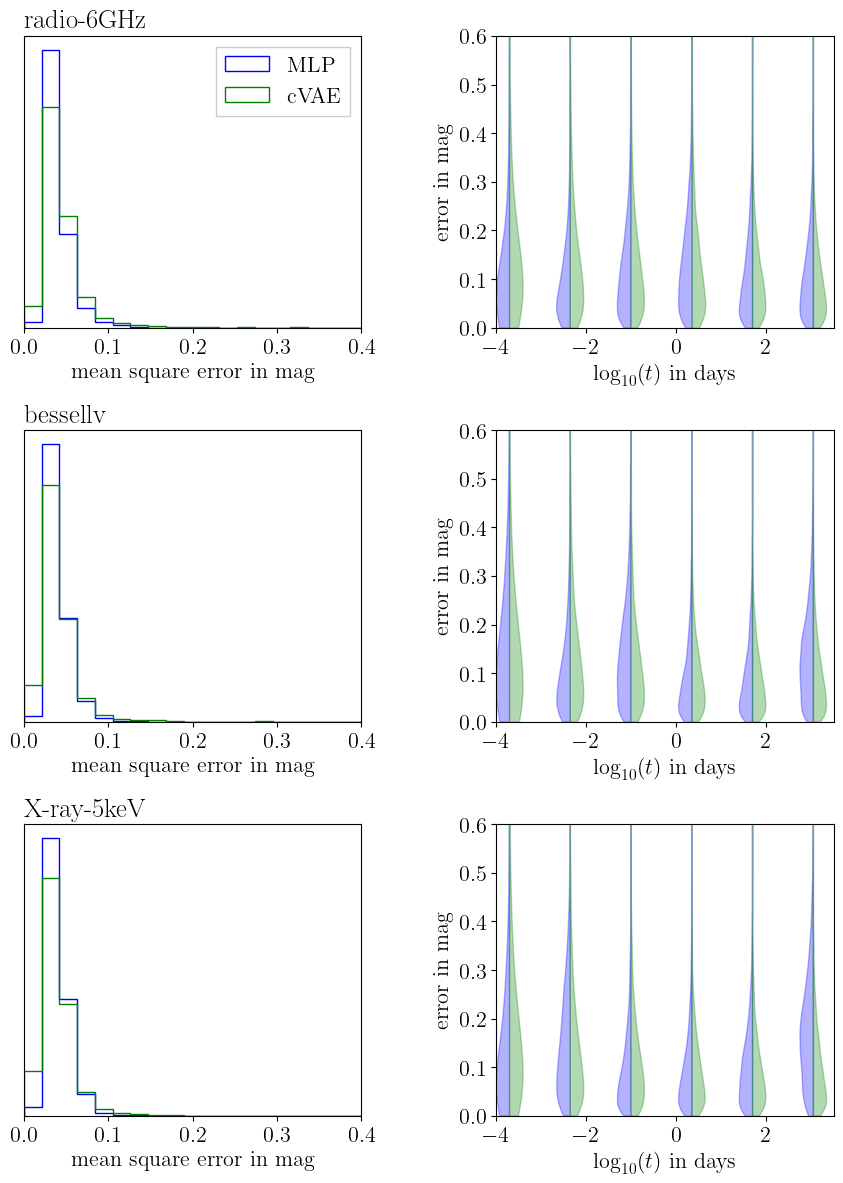

In [32]:
fig, ax = plt.subplots(3, 2, figsize = (9, 12))
fig.subplots_adjust(wspace = 0.4, hspace =0.35, bottom = 0.05, top = 0.95, left = 0.05, right = 0.95)

for filter, cax in zip(FILTERS, ax[:,0]):

    cax.hist(benchmarker1.error[filter], color = "blue", histtype = "step", bins = np.linspace(0, 0.4, 20), density = True, label = "MLP")
    cax.hist(benchmarker2.error[filter], color = "green", histtype = "step", bins = np.linspace(0, 0.4, 20), density = True, label = "cVAE")
    cax.set_yticks([])
    cax.set_xlabel("mean square error in mag")
    cax.set_xlim((0,0.4))
    cax.set_title(filter, loc = "left")

for filter, cax in zip(FILTERS, ax[:,1]):
    error = np.abs(benchmarker1.pred_mag[filter] - benchmarker1.test_mag[filter])
    error[np.isinf(error) | np.isnan(error)] = 0.
    indices = np.linspace(10, len(model1.times)-10, 6).astype(int)
    parts1 = cax.violinplot(error[:, indices], positions=np.log10(model1.times[indices]), widths=0.6, side="low", showextrema=False, points=500)
    for pc in parts1["bodies"]:
        pc.set_facecolor("blue")
        pc.set_edgecolor("blue")

    error = np.abs(benchmarker2.pred_mag[filter] - benchmarker2.test_mag[filter])
    error[np.isinf(error) | np.isnan(error)] = 0.
    indices = np.linspace(10, len(model2.times)-10, 6).astype(int)
    parts2 = cax.violinplot(error[:, indices], positions=np.log10(model2.times[indices]), widths=0.6, side="high", showextrema=False, points=500)
    for pc in parts2["bodies"]:
        pc.set_facecolor("green")
        pc.set_edgecolor("green")

    cax.set(xlabel = "$\\log_{10}(t)$ in days", ylabel = "error in mag", xscale = "linear", xlim = (-4., 3.5), ylim = (0,0.6))

ax[0,0].legend(fancybox=False, framealpha=1, fontsize = 16)
fig.savefig("./benchmark_afgpy_gaussian.pdf", dpi =300)

In [50]:
high_error_fraction(benchmarker2.test_mag, benchmarker2.pred_mag, "bessellv")

0.05600612088752869

16:12 fiesta INFO    : Loading surrogate afgpy_tophat. This surrogate should only be used in the following parameter ranges:
16:12 fiesta INFO    : 	 inclination_EM: (0, 1.5707963267948966)
16:12 fiesta INFO    : 	 log10_E0: (47, 57)
16:12 fiesta INFO    : 	 thetaCore: (0.01, 0.6283185307179586)
16:12 fiesta INFO    : 	 log10_n0: (-6, 2)
16:12 fiesta INFO    : 	 p: (2.01, 3)
16:12 fiesta INFO    : 	 log10_epsilon_e: (-4, 0)
16:12 fiesta INFO    : 	 log10_epsilon_B: (-8, 0)
16:12 fiesta INFO    : Surrogate afgpy_tophat is loading with the following filters: ['X-ray-1keV'].
16:12 fiesta INFO    : Loaded for surrogate afgpy_tophat from /nfs/aya/work/hkoehn/fiesta/fiesta/surrogates/GRB/afgpy_tophat_CVAE/model.


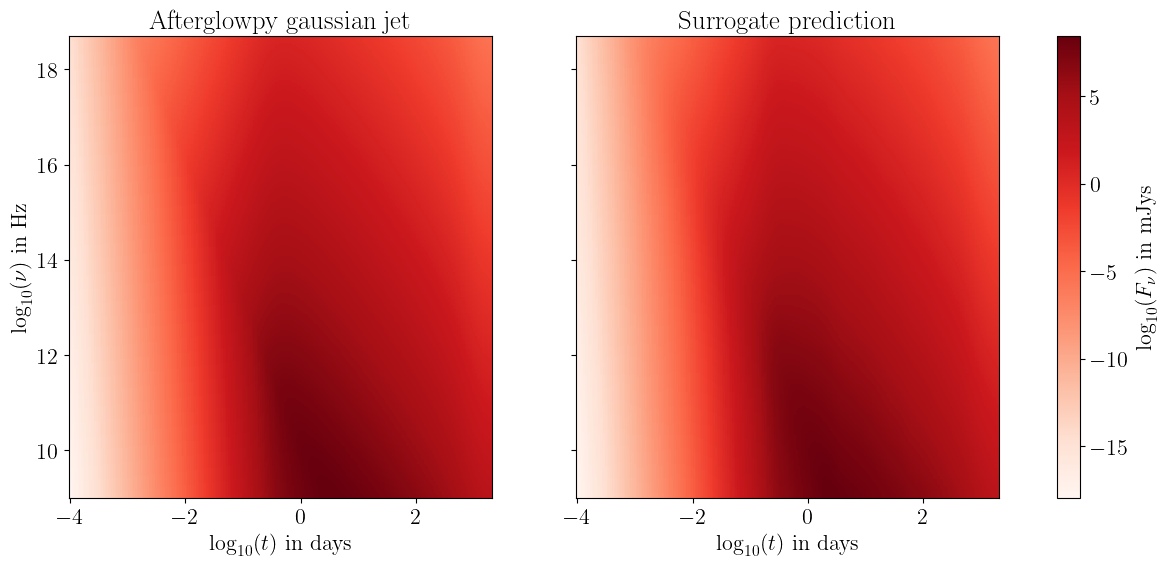

In [35]:
import h5py
import matplotlib.colors as colors

with h5py.File("/home/aya/work/hkoehn/fiesta/fiesta/surrogates/GRB/training_data/afterglowpy_tophat_raw_data.h5") as f:
    nus = f["nus"][:]
    times = f["times"][:]
    x = f["test"]["X"][64]
    y = f["test"]["y"][64]

model2 = AfterglowFlux("afgpy_tophat",
                        filters = ["X-ray-1keV"])

cmap = colors.ListedColormap(["white", "red"])

predict_y = model2.predict_log_flux(x)

fig, ax = plt.subplots(1, 2, figsize=(15,6), sharex=True, sharey=True)

ax[0].pcolormesh(np.log10(times), np.log10(nus), y.reshape(256, 250)/np.log(10), cmap="Reds")
ax[0].set_ylim(np.log10(model2.nus[0]), np.log10(model2.nus[-1]))
ax[0].set_xlabel("$\\log_{10}(t)$ in days")
ax[0].set_ylabel("$\\log_{10}(\\nu)$ in Hz")
ax[0].set_title("Afterglowpy gaussian jet")


qmesh = ax[1].pcolormesh(np.log10(model2.times), np.log10(model2.nus), predict_y/np.log(10), cmap="Reds")
ax[1].set_xlabel("$\\log_{10}(t)$ in days")
#ax[1].set_ylabel("$\\log_{10}(\\nu)$ in Hz")
ax[1].set_title("Surrogate prediction")


plt.colorbar(qmesh, ax=ax, label="$\\log_{10}(F_\\nu)$ in mJys")


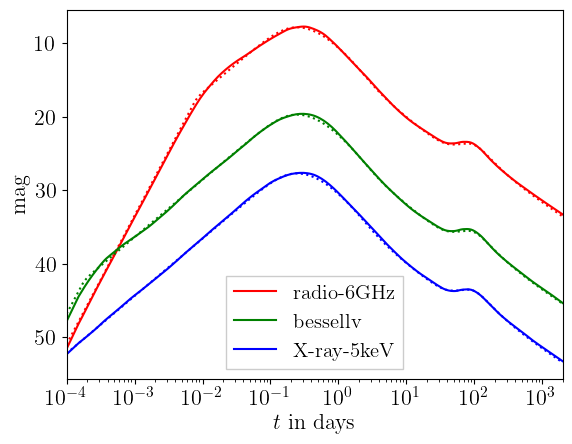

In [8]:
times, pred = model2.predict_abs_mag(dict(zip(model2.parameter_names, benchmarker2.test_X_raw[64])))

for color, filt in zip(["red", "green", "blue"],["radio-6GHz", "bessellv", "X-ray-5keV"]):
    plt.plot(times, pred[filt], color=color, label=filt)
    plt.plot(times, benchmarker2.test_mag[filt][64], linestyle="dotted", color=color)
 

plt.xscale("log")
plt.xlim(1e-4, 2e3)
plt.xlabel("$t$ in days")
plt.ylabel("mag")
plt.gca().invert_yaxis()
plt.plot()
plt.legend(fontsize=15, fancybox=False, framealpha=1)

## Pyblastafterglow tophat

In [51]:
FILTERS = ["radio-6GHz", "bessellv", "X-ray-5keV"]


model1 = AfterglowFlux("pbag_tophat_MLP",
                        filters = FILTERS)

model2 = AfterglowFlux("pbag_tophat",
                        filters = FILTERS)


benchmarker1 = Benchmarker(
                    model = model1,
                    data_file = "/home/aya/work/hkoehn/fiesta/fiesta/surrogates/GRB/training_data/pyblastafterglow_tophat_raw_data.h5",
                    metric_name = "L2"
                    )

benchmarker2 = Benchmarker(
                    model = model2,
                    data_file = "/home/aya/work/hkoehn/fiesta/fiesta/surrogates/GRB/training_data/pyblastafterglow_tophat_raw_data.h5",
                    metric_name = "L2"
                    )

18:07 fiesta INFO    : Loading surrogate pbag_tophat_MLP. This surrogate should only be used in the following parameter ranges:
18:07 fiesta INFO    : 	 inclination_EM: (0, 1.5707963267948966)
18:07 fiesta INFO    : 	 log10_E0: (47, 57)
18:07 fiesta INFO    : 	 thetaCore: (0.01, 0.6283185307179586)
18:07 fiesta INFO    : 	 log10_n0: (-6, 2)
18:07 fiesta INFO    : 	 p: (2.01, 3)
18:07 fiesta INFO    : 	 log10_epsilon_e: (-4, 0)
18:07 fiesta INFO    : 	 log10_epsilon_B: (-8, 0)
18:07 fiesta INFO    : 	 Gamma0: (100, 1000)
18:07 fiesta INFO    : Surrogate pbag_tophat_MLP is loading with the following filters: ['radio-6GHz', 'bessellv', 'X-ray-5keV'].
18:07 fiesta INFO    : Loaded for surrogate pbag_tophat_MLP from /nfs/aya/work/hkoehn/fiesta/fiesta/surrogates/GRB/pbag_tophat_MLP/model.
18:07 fiesta INFO    : Loading surrogate pbag_tophat. This surrogate should only be used in the following parameter ranges:
18:07 fiesta INFO    : 	 inclination_EM: (0, 1.5707963267948966)
18:07 fiesta INFO

Loaded filters are: ['radio-6GHz', 'bessellv', 'X-ray-5keV'].
Loaded filters are: ['radio-6GHz', 'bessellv', 'X-ray-5keV'].


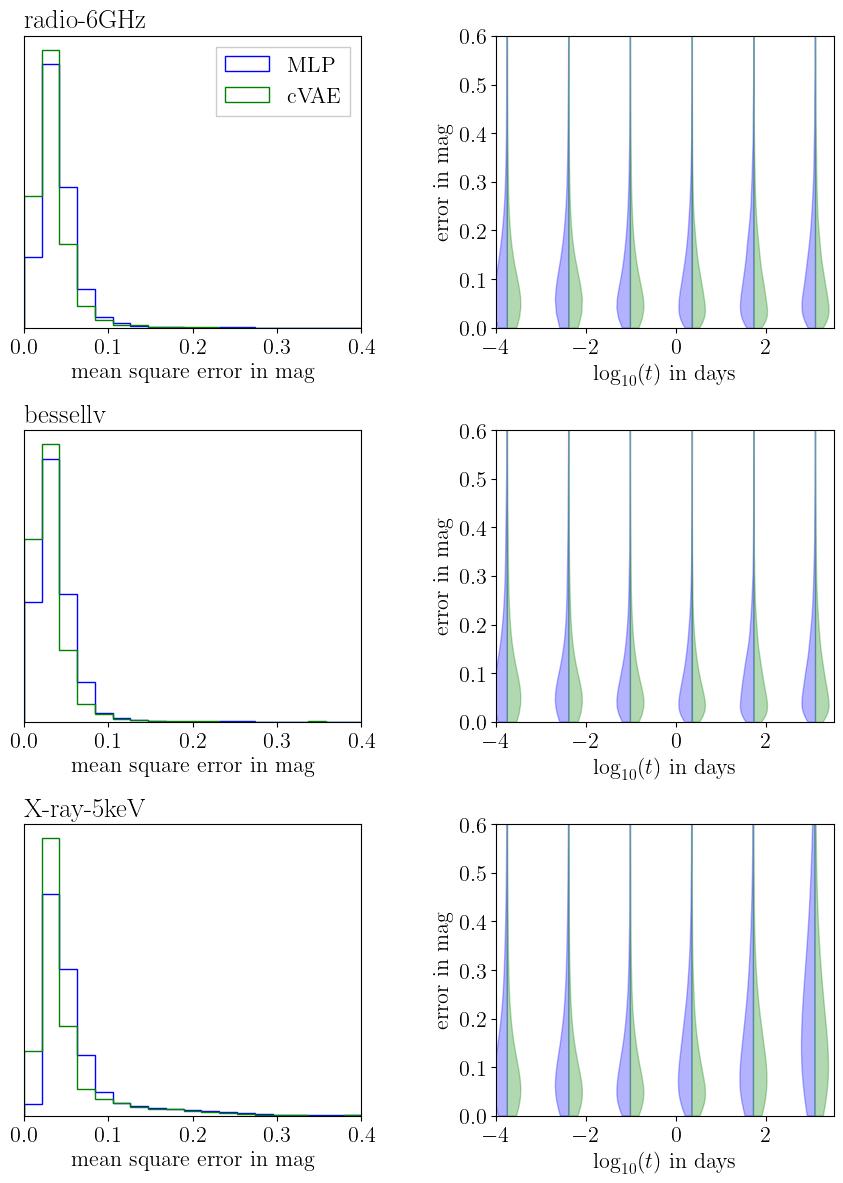

In [52]:
fig, ax = plt.subplots(3, 2, figsize = (9, 12))
fig.subplots_adjust(wspace = 0.4, hspace =0.35, bottom = 0.05, top = 0.95, left = 0.05, right = 0.95)

for filter, cax in zip(FILTERS, ax[:,0]):

    cax.hist(benchmarker1.error[filter], color = "blue", histtype = "step", bins = np.linspace(0, 0.4, 20), density = True, label = "MLP")
    cax.hist(benchmarker2.error[filter], color = "green", histtype = "step", bins = np.linspace(0, 0.4, 20), density = True, label = "cVAE")
    cax.set_yticks([])
    cax.set_xlabel("mean square error in mag")
    cax.set_xlim((0,0.4))
    cax.set_title(filter, loc = "left")

for filter, cax in zip(FILTERS, ax[:,1]):
    error = np.abs(benchmarker1.pred_mag[filter] - benchmarker1.test_mag[filter])
    error[np.isinf(error) | np.isnan(error)] = 0.
    indices = np.linspace(10, len(model1.times)-10, 6).astype(int)
    parts1 = cax.violinplot(error[:, indices], positions=np.log10(model1.times[indices]), widths=0.6, side="low", showextrema=False, points=500)
    for pc in parts1["bodies"]:
        pc.set_facecolor("blue")
        pc.set_edgecolor("blue")

    error = np.abs(benchmarker2.pred_mag[filter] - benchmarker2.test_mag[filter])
    error[np.isinf(error) | np.isnan(error)] = 0.
    indices = np.linspace(10, len(model2.times)-10, 6).astype(int)
    parts2 = cax.violinplot(error[:, indices], positions=np.log10(model2.times[indices]), widths=0.6, side="high", showextrema=False, points=500)
    for pc in parts2["bodies"]:
        pc.set_facecolor("green")
        pc.set_edgecolor("green")

    cax.set(xlabel = "$\\log_{10}(t)$ in days", ylabel = "error in mag", xscale = "linear", xlim = (-4., 3.5), ylim = (0,0.6))

ax[0,0].legend(fancybox=False, framealpha=1, fontsize = 16)
fig.savefig("./benchmark_pbag_tophat.pdf", dpi =300)

In [53]:
high_error_fraction(benchmarker2.test_mag, benchmarker2.pred_mag, "bessellv")

0.033463541666666666

## Pyblastafterglow gaussian

In [5]:
FILTERS = ["radio-6GHz", "bessellv", "X-ray-5keV"]


model1 = AfterglowFlux("pbag_gaussian_MLP",
                        filters = FILTERS)

model2 = AfterglowFlux("pbag_gaussian",
                        filters = FILTERS)


benchmarker1 = Benchmarker(
                    model = model1,
                    data_file = "/home/aya/work/hkoehn/fiesta/fiesta/surrogates/GRB/training_data/pyblastafterglow_gaussian_raw_data.h5",
                    metric_name = "L2"
                    )

benchmarker2 = Benchmarker(
                    model = model2,
                    data_file = "/home/aya/work/hkoehn/fiesta/fiesta/surrogates/GRB/training_data/pyblastafterglow_gaussian_raw_data.h5",
                    metric_name = "L2"
                    )

12:03 fiesta INFO    : Loading surrogate pbag_gaussian_MLP. This surrogate should only be used in the following parameter ranges:
12:03 fiesta INFO    : 	 inclination_EM: (0, 1.5707963267948966)
12:03 fiesta INFO    : 	 log10_E0: (47, 57)
12:03 fiesta INFO    : 	 thetaCore: (0.01, 0.6283185307179586)
12:03 fiesta INFO    : 	 alphaWing: (0.2, 3.5)
12:03 fiesta INFO    : 	 log10_n0: (-6, 2)
12:03 fiesta INFO    : 	 p: (2.01, 3)
12:03 fiesta INFO    : 	 log10_epsilon_e: (-4, 0)
12:03 fiesta INFO    : 	 log10_epsilon_B: (-8, 0)
12:03 fiesta INFO    : 	 Gamma0: (100, 1000)
12:03 fiesta INFO    : Surrogate pbag_gaussian_MLP is loading with the following filters: ['radio-6GHz', 'bessellv', 'X-ray-5keV'].
12:03 fiesta INFO    : Loaded for surrogate pbag_gaussian_MLP from /nfs/aya/work/hkoehn/fiesta/fiesta/surrogates/GRB/pbag_gaussian_MLP/model.
12:03 fiesta INFO    : Loading surrogate pbag_gaussian. This surrogate should only be used in the following parameter ranges:
12:03 fiesta INFO    : 	 

Loaded filters are: ['radio-6GHz', 'bessellv', 'X-ray-5keV'].
Loaded filters are: ['radio-6GHz', 'bessellv', 'X-ray-5keV'].


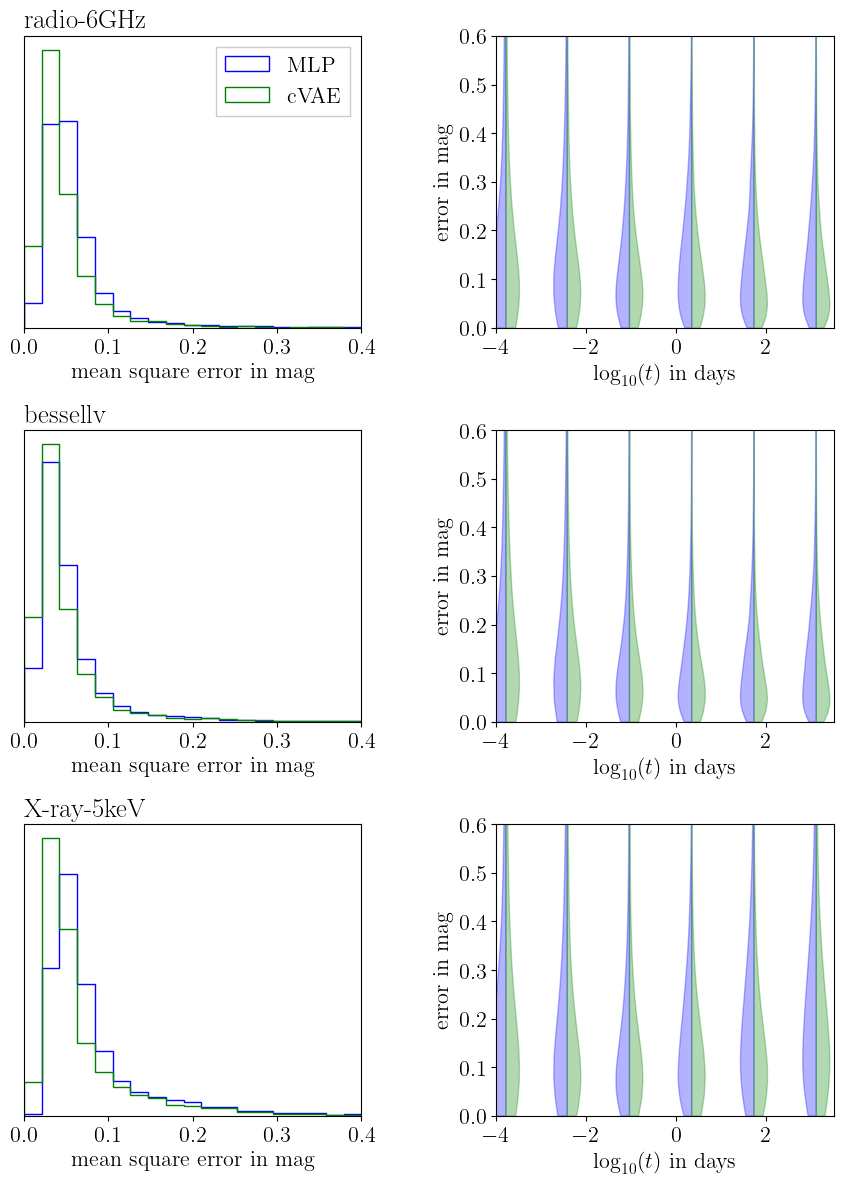

In [7]:
fig, ax = plt.subplots(3, 2, figsize = (9, 12))
fig.subplots_adjust(wspace = 0.4, hspace =0.35, bottom = 0.05, top = 0.95, left = 0.05, right = 0.95)

for filter, cax in zip(FILTERS, ax[:,0]):

    cax.hist(benchmarker1.error[filter], color = "blue", histtype = "step", bins = np.linspace(0, 0.4, 20), density = True, label = "MLP")
    cax.hist(benchmarker2.error[filter], color = "green", histtype = "step", bins = np.linspace(0, 0.4, 20), density = True, label = "cVAE")
    cax.set_yticks([])
    cax.set_xlabel("mean square error in mag")
    cax.set_xlim((0,0.4))
    cax.set_title(filter, loc = "left")

for filter, cax in zip(FILTERS, ax[:,1]):
    error = np.abs(benchmarker1.pred_mag[filter] - benchmarker1.test_mag[filter])
    error[np.isinf(error) | np.isnan(error)] = 0.
    indices = np.linspace(10, len(model1.times)-10, 6).astype(int)
    parts1 = cax.violinplot(error[:, indices], positions=np.log10(model1.times[indices]), widths=0.6, side="low", showextrema=False, points=500)
    for pc in parts1["bodies"]:
        pc.set_facecolor("blue")
        pc.set_edgecolor("blue")

    error = np.abs(benchmarker2.pred_mag[filter] - benchmarker2.test_mag[filter])
    error[np.isinf(error) | np.isnan(error)] = 0.
    indices = np.linspace(10, len(model2.times)-10, 6).astype(int)
    parts2 = cax.violinplot(error[:, indices], positions=np.log10(model2.times[indices]), widths=0.6, side="high", showextrema=False, points=500)
    for pc in parts2["bodies"]:
        pc.set_facecolor("green")
        pc.set_edgecolor("green")

    cax.set(xlabel = "$\\log_{10}(t)$ in days", ylabel = "error in mag", xscale = "linear", xlim = (-4., 3.5), ylim = (0,0.6))

ax[0,0].legend(fancybox=False, framealpha=1, fontsize = 16)
fig.savefig("./benchmark_pbag_gaussian.pdf", dpi =300)

In [12]:
high_error_fraction(benchmarker2.test_mag, benchmarker2.pred_mag, "X-ray-5keV")

0.238108407079646

## Bu2025

In [56]:
FILTERS = ["2massj", "ps1::g", "sdssu"]


model1 = BullaLightcurveModel("Bu2025",
                        filters = FILTERS)

model2 = AfterglowFlux("Bu2025_CVAE",
                               filters = FILTERS)


benchmarker1 = Benchmarker(
                    model = model1,
                    data_file = "/work/koehn1/fiesta/fiesta/surrogates/KN/training_data/Bu2025_raw_data.h5",
                    metric_name = "L2"
                    )

benchmarker2 = Benchmarker(
                    model = model2,
                    data_file = "/work/koehn1/fiesta/fiesta/surrogates/KN/training_data/Bu2025_raw_data.h5",
                    metric_name = "L2"
                    )

11:53 fiesta INFO    : Loading surrogate Bu2025. This surrogate should only be used in the following parameter ranges:
11:53 fiesta INFO    : 	 log10_mej_dyn: (-3.0, -1.3010299956639813)
11:53 fiesta INFO    : 	 v_ej_dyn: (0.12, 0.28)
11:53 fiesta INFO    : 	 Ye_dyn: (0.15, 0.35)
11:53 fiesta INFO    : 	 log10_mej_wind: (-2.0, -0.8860566476931633)
11:53 fiesta INFO    : 	 v_ej_wind: (0.05, 0.15)
11:53 fiesta INFO    : 	 Ye_wind: (0.2, 0.4)
11:53 fiesta INFO    : 	 inclination_EM: (0.0, 90.0)
11:53 fiesta INFO    : 	 redshift: (0, 0.5)
11:53 fiesta INFO    : Surrogate Bu2025 is loading with the following filters: ['2massj', 'ps1::g', 'sdssu'].
11:53 fiesta INFO    : Loaded for surrogate Bu2025 from /work/koehn1/fiesta/fiesta/surrogates/KN/Bu2025_lc/model.
11:53 fiesta INFO    : Loading surrogate Bu2025_CVAE. This surrogate should only be used in the following parameter ranges:
11:53 fiesta INFO    : 	 log10_mej_dyn: (-3.0, -1.3010299956639813)
11:53 fiesta INFO    : 	 v_ej_dyn: (0.12, 0

Loaded filters are: ['2massj', 'ps1::g', 'sdssu'].
Loaded filters are: ['2massj', 'ps1::g', 'sdssu'].


findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following

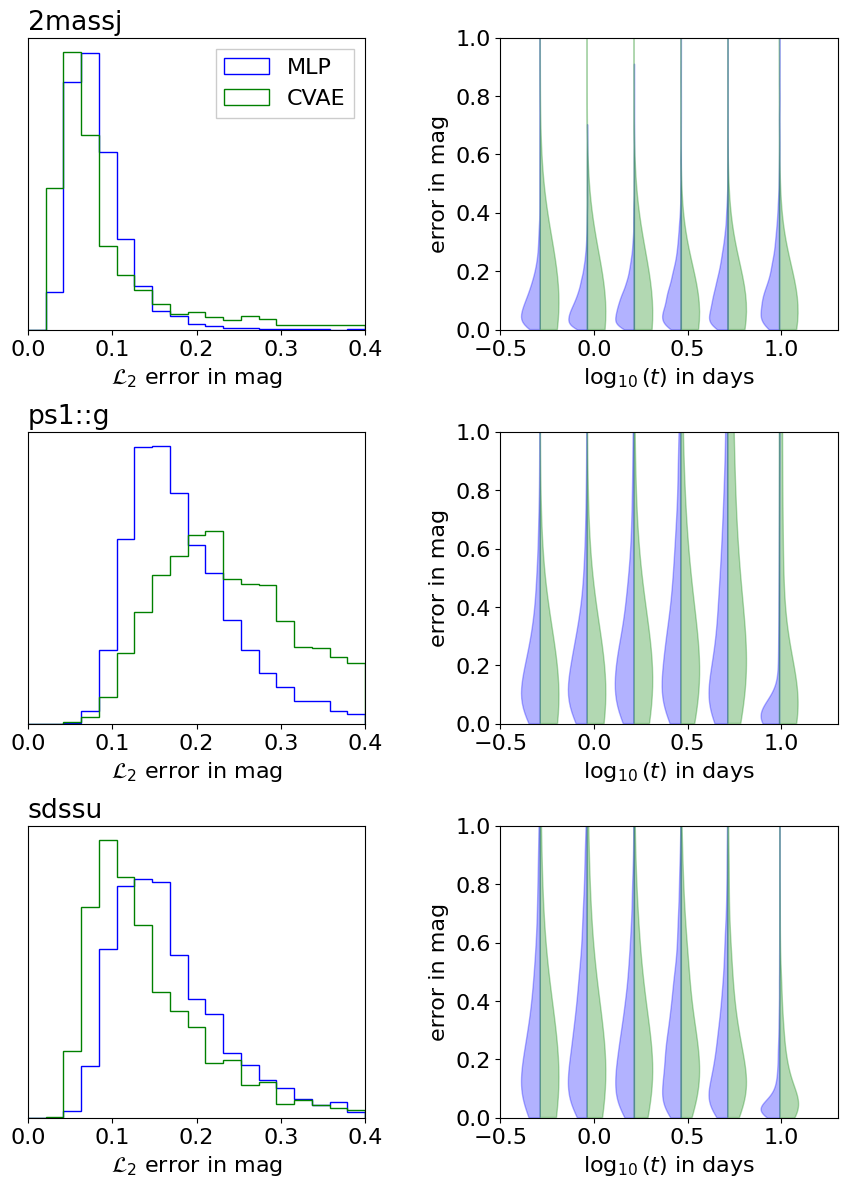

In [59]:
fig, ax = plt.subplots(3, 2, figsize = (9, 12))
fig.subplots_adjust(wspace = 0.4, hspace =0.35, bottom = 0.05, top = 0.95, left = 0.05, right = 0.95)

for filter, cax in zip(FILTERS, ax[:,0]):

    cax.hist(benchmarker1.error[filter], color = "blue", histtype = "step", bins = np.linspace(0, 0.4, 20), density = True, label = "MLP")
    cax.hist(benchmarker2.error[filter], color = "green", histtype = "step", bins = np.linspace(0, 0.4, 20), density = True, label = "CVAE")
    cax.set_yticks([])
    cax.set_xlabel("$\mathcal{L}_2$ error in mag")
    cax.set_xlim((0,0.4))
    cax.set_title(filter, loc = "left")

for filter, cax in zip(FILTERS, ax[:,1]):
    error = np.abs(benchmarker1.pred_mag[filter] - benchmarker1.test_mag[filter])
    error[np.isinf(error) | np.isnan(error)] = 0.
    indices = np.linspace(10, len(model1.times)-10, 6).astype(int)
    parts1 = cax.violinplot(error[:, indices], positions=np.log10(model1.times[indices]), widths=0.2, side="low", showextrema=False, points=500)
    for pc in parts1["bodies"]:
        pc.set_facecolor("blue")
        pc.set_edgecolor("blue")

    error = np.abs(benchmarker2.pred_mag[filter] - benchmarker2.test_mag[filter])
    error[np.isinf(error) | np.isnan(error)] = 0.
    indices = np.linspace(10, len(model2.times)-10, 6).astype(int)
    parts2 = cax.violinplot(error[:, indices], positions=np.log10(model2.times[indices]), widths=0.2, side="high", showextrema=False, points=500)
    for pc in parts2["bodies"]:
        pc.set_facecolor("green")
        pc.set_edgecolor("green")

    cax.set(xlabel = "$\\log_{10}(t)$ in days", ylabel = "error in mag", xscale = "linear", xlim = (-0.5, np.log10(20)), ylim = (0,1))

ax[0,0].legend(fancybox=False, framealpha=1, fontsize = 16)
fig.savefig("./benchmark_Bu2025.pdf", dpi=250)

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following

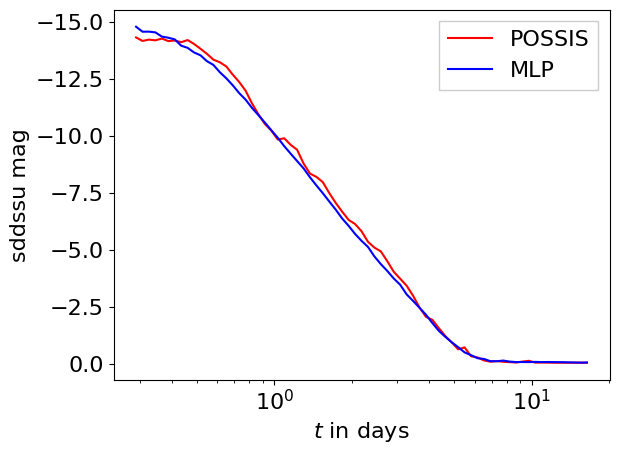

In [65]:
ind = 1
plt.plot(model1.times, benchmarker1.test_mag["sdssu"][ind], color="red", label="POSSIS")
plt.plot(model1.times, benchmarker1.pred_mag["sdssu"][ind], color="blue", label="MLP")
plt.gca().invert_yaxis()
plt.xlabel("$t$ in days")
plt.ylabel("sddssu mag")
plt.xscale("log")
plt.legend(fancybox=False, framealpha=1)

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following

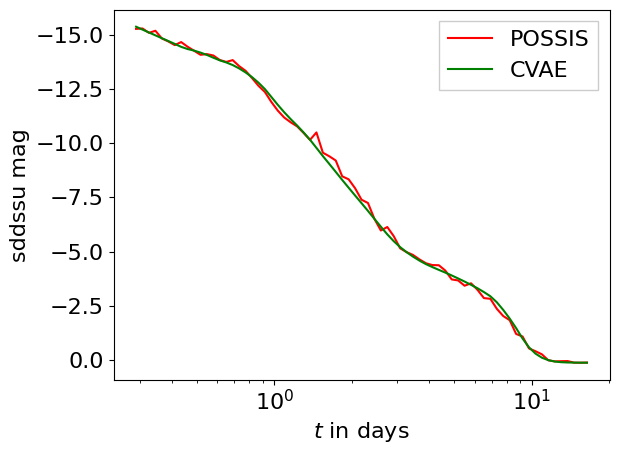

In [67]:
ind = 2000
plt.plot(model2.times, benchmarker2.test_mag["sdssu"][ind], color="red", label="POSSIS")
plt.plot(model2.times, benchmarker2.pred_mag["sdssu"][ind], color="green", label="CVAE")
plt.gca().invert_yaxis()
plt.xlabel("$t$ in days")
plt.ylabel("sddssu mag")
plt.xscale("log")   
plt.legend(fancybox=False, framealpha=1)

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following

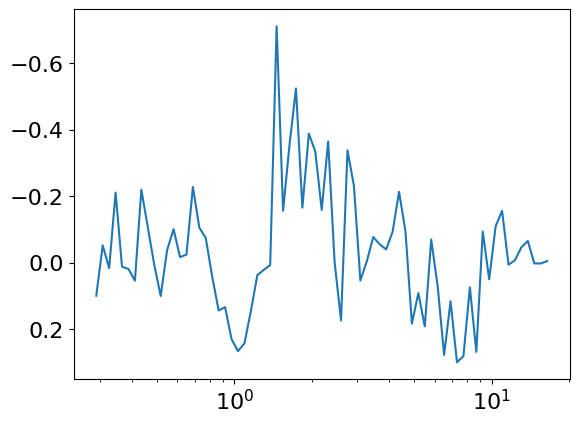

In [68]:
plt.plot(model2.times, benchmarker2.test_mag["sdssu"][ind] - benchmarker2.pred_mag["sdssu"][ind])
plt.gca().invert_yaxis()
plt.xscale("log")

In [49]:
print(np.sort(benchmarker1.error["sdssu"])[2000])
print(np.argsort(benchmarker1.error["sdssu"])[2000])

0.14849122296453188
3199


In [45]:
benchmarker1.error["sdssu"].shape

(4527,)